## Import files for analysis

Using counts of reads mapped to protein coding genes from the Psa-V genome and plasmid. Files generated by 
kallisto.

Experiment summary:

| Filename	| Sample name |	Growth Condition |	Growth stage |
|  -------- | ---------   | -----------------| ------------- |
| 2428-01-2-1_S1_L001_R1_001 | M9-1	| Minimal media (M9) | Log/Late log phase |
| 2428-02-2-1_S2_L001_R1_001 | M9-2 | Minimal media (M9) | Log/Late log phase |
| 2428-03-2-1_S3_L001_R1_001 | LB-3	| Rich media (LB) | Late log phase |
| 2428-04-2-1_S4_L001_R1_001 | LB-4	| Rich media (LB) | Late log phase |
| 2428-05-2-1_S5_L001_R1_001 | ST-5 | Starved | 0.1 M9 salts |	
| 2428-06-2-1_S6_L001_R1_001 | ST-6 | Starved | 0.1 M9 salts |	
| 2428-07-2-1_S7_L001_R1_001 | LB-7 | Rich media (LB) | Log phase |
| 2428-08-2-1_S8_L001_R1_001 | LB-8	| Rich media (LB) | Log phase |
| 2428-09-2-1_S9_L001_R1_001 | LB-9	| Rich media (LB) |	Log phase |
| 2428-10-2-1_S10_L001_R1_001 |	LBA-10	| Rich media (LB) |	Log phase |
| 2428-11-2-1_S11_L001_R1_001 | ST-11 | Starved | 0.1 M9 salts |
| 2428-12-2-1_S12_L001_R1_001 | ST-12 | Starved | 0.1 M9 salts |
			



In [1]:
library(tximport)
library(readr)
library(DESeq2)
library(ggplot2)
library(ggrepel)

#read in samples in kallisto tsv format using tximport
samples <- read.table("mapping/sample_paths_in_vitro.txt",
        header = FALSE,
        stringsAsFactors = FALSE)

files <- file.path(samples$V1)
names(files) <- levels(samples$V1) 

##tx2gene is a file of gene names required by kallisto for naming transcripts
tx2gene <- read.csv("DESeq_analysis/fake_tx2gene.csv")
txi.kallisto.tsv <- tximport(
            files,
            type = "kallisto",
            tx2gene=tx2gene)


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

## Test effects of experiment design

1. Principal Component Analysis 

Are samples of the same media/growth phase similar and distinct from other conditions?

In [2]:
#to test the effect of factors, make table of experimental design 
#where media and growth phase factors are combined
sampleTable <-read.csv("mapping/sample_list_combo.csv", 
        header = TRUE)
rownames(sampleTable) <- colnames(txi.kallisto.tsv$counts)
print(sampleTable)

      sample sample_name                media
1   Sample_1        M9-1 minimal_log_late_log
2   Sample_2        M9-2 minimal_log_late_log
3   Sample_3        LB-3        rich_log_late
4   Sample_4        LB-4        rich_log_late
5   Sample_5        ST-5        starved_early
6   Sample_6        ST-6        starved_early
7   Sample_7        LB-7             rich_log
8   Sample_8        LB-8             rich_log
9   Sample_9        LB-9             rich_log
10 Sample_10      LBA-10             rich_log
11 Sample_11       ST-11        starved_early
12 Sample_12       ST-12        starved_early


In [3]:
#run DESeq2 using this experiment design and log normalise counts
ddsTxi <- DESeqDataSetFromTximport(
        txi.kallisto.tsv,
        colData = sampleTable,
        design= ~ media)
#filter rows with no counts
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,]
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)

using counts and average transcript lengths from tximport
estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


      Length        Class         Mode 
        5818 DESeqDataSet           S4 

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


png 
  2

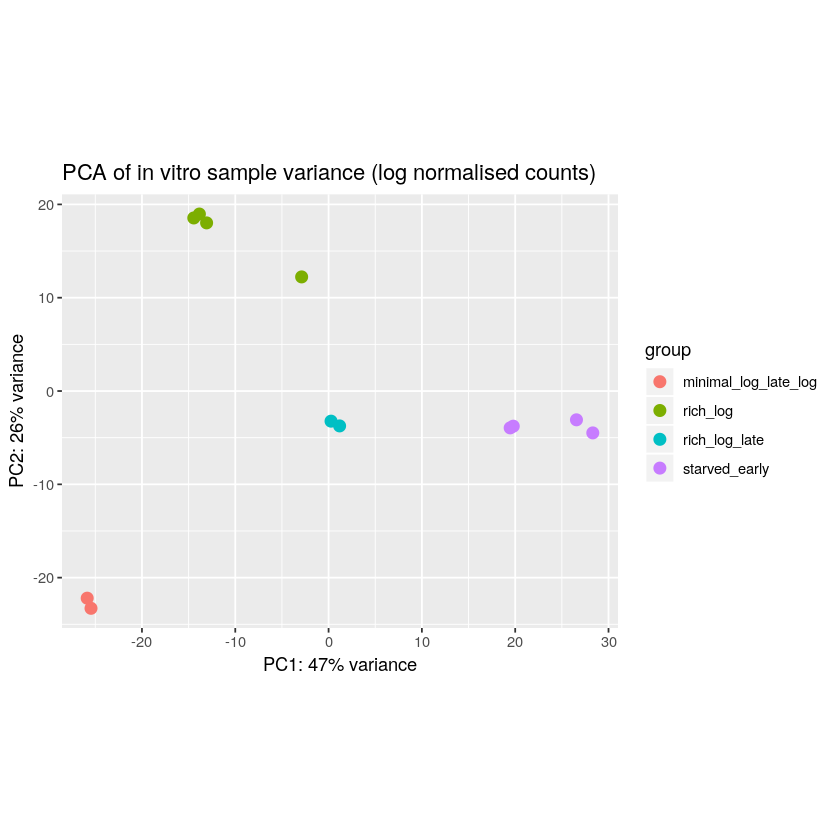

In [4]:
#generate PCA plot comparing combined effect of media and growth phase
pca <- plotPCA(rld, intgroup="media")
library(ggrepel)
#add plot title and point labels
pca <- pca + (
        ggtitle(
        aes(
            label = "PCA of in vitro sample variance (log normalised counts)")))
pdf("DESeq_analysis/plots/in_vitro/PCA_all_samples.pdf")
pca
dev.off()
pca

Media type (rich, minimal, starved) has the biggest effect on variance in PC1. However there is a significant proportion of variance that appears to be due to the two distinct growth phases witin the rich media sample. Sample 10 showed a significant difference compared to the other rich_log samples - ribo-zero didn't work as well. 


png 
  2

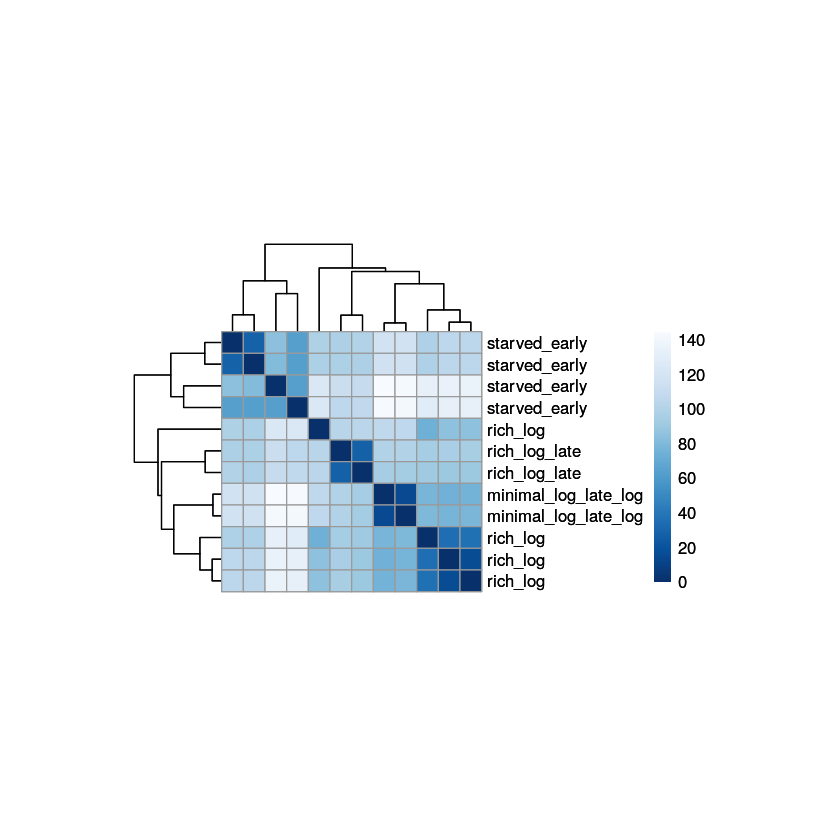

In [5]:
#hierarchical clustering of sample distances

#extract sample-sample variance (stabilised and 
#corrected for size factors and normalization factors)
vsd <- vst(ddsTxi, blind=FALSE)
#measure distances between samples
sampleDists <- dist(t(assay(vsd)))

library("RColorBrewer")
library("pheatmap")

#convert sample-sample distances to matrix
sampleDistMatrix <- as.matrix(sampleDists)
#rename rows with combined media/growth phase factors
rownames(sampleDistMatrix) <- paste(vsd$media)
#remove column names
colnames(sampleDistMatrix) <- NULL
#set heatmap colour pallette to blues
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
#plot clustered heatmap of sample-sample distances
p <- pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         cellwidth = 13,
         cellheight = 13)
pdf("DESeq_analysis/plots/in_vitro/distance_heatmap_all_samples.pdf")
p
dev.off()
p

In [6]:
#To drop sample 10 from the analysis
#re-load sample list without sample 10
new_samples <- read.table(
        "mapping/samples_no_sample_10.txt",
        header = FALSE)
#re-load all samples in kallisto tsv format using tximport
files <- file.path(new_samples$V1)
names(files) <- levels(new_samples$V1)
txi.kallisto.tsv <- tximport(
        files,
        type = "kallisto",
        tx2gene=tx2gene)

#make table of countfiles for all experiments (except sample 10)
sampleTable <-read.csv("mapping/sample_list_combo_no_sample10.csv",
        header = TRUE)

#make table of experimental design
rownames(sampleTable) <- colnames(txi.kallisto.tsv$counts)

#create DESeq2 object with media as factor
ddsTxi <- DESeqDataSetFromTximport(txi.kallisto.tsv,
                                   colData = sampleTable,
                                   design = ~ media)



Note: importing `abundance.h5` is typically faster than `abundance.tsv`
reading in files with read_tsv
1 2 3 4 5 6 7 8 9 10 11 
summarizing abundance
summarizing counts
summarizing length
using counts and average transcript lengths from tximport


In [7]:
#How many genes weren't expressed?
#noexp <- ddsTxi[rowSums(counts(ddsTxi)) < 1,]
#lowexp <- ddsTxi[rowSums(counts(ddsTxi)) < 25,]
#lowexp2 <- ddsTxi[rowSums(counts(ddsTxi)) < 50,]
#how many genes have no counts?
#print(nrow(noexp))
#which genes?
#print(rownames(noexp))
#how many genes have < 25 counts?
#print(nrow(lowexp))
#which genes?
#print(rownames(lowexp))
#how many genes have < 50 counts?
#print(nrow(lowexp2))
#write gene names with < 50 counts to file "rownames.txt"
#write.csv(file="rownames.txt",rownames(lowexp2))

In [8]:
#filter rows with no counts
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,]
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)

estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


      Length        Class         Mode 
        5818 DESeqDataSet           S4 

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


png 
  2

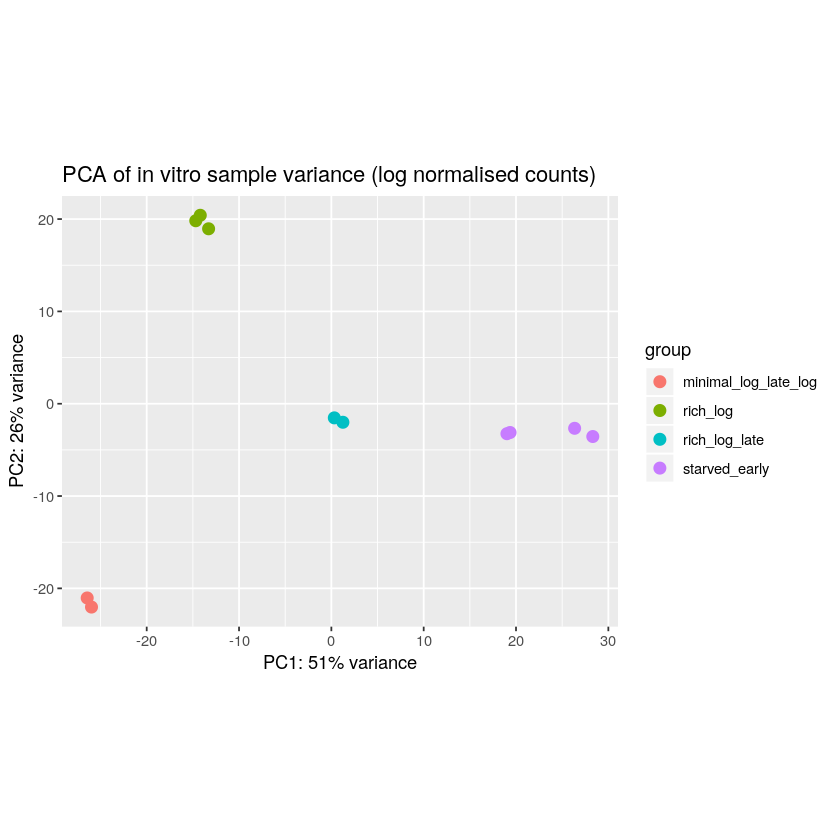

In [9]:
#generate PCA plot without sample 10
pca <- plotPCA(rld, intgroup="media")
pca <- pca + (
    ggtitle(
        aes(
            label = "PCA of in vitro sample variance (log normalised counts)")))

pdf("DESeq_analysis/plots/in_vitro/PCA_final_samples.pdf")
pca
dev.off()
pca

In [10]:
#generate hierarchical clustering plot without sample 10
vsd <- vst(ddsTxi, blind=FALSE)
sampleDists <- dist(t(assay(vsd)))


png 
  2

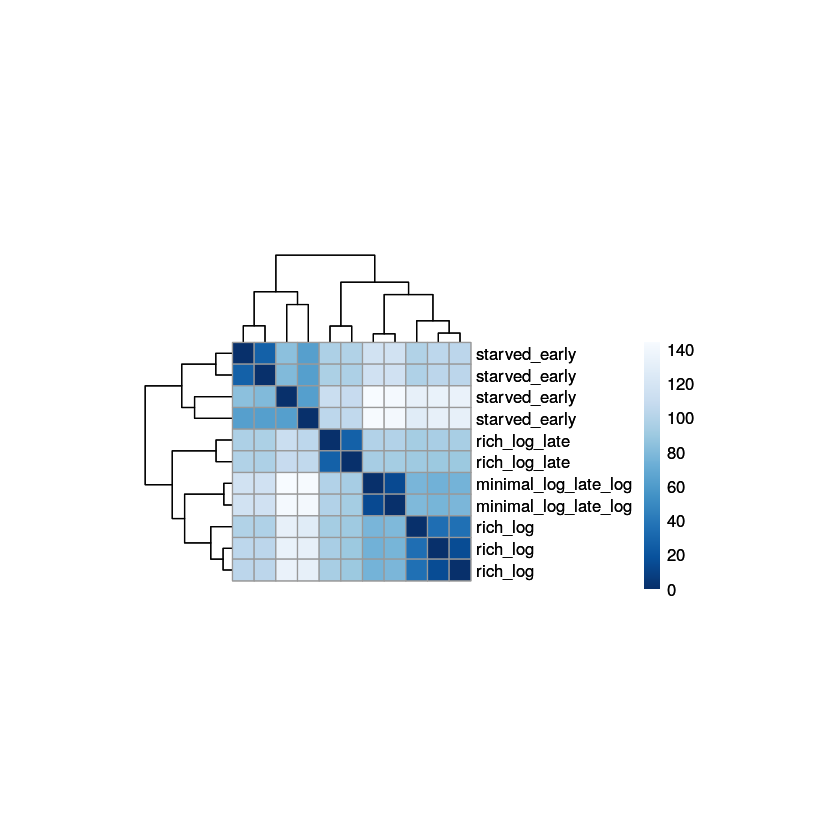

In [11]:
library("RColorBrewer")
library("pheatmap")
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$media)
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette(
    rev(
        brewer.pal(
            9,
            "Blues")))(255)
p <- pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         cellwidth = 13,
         cellheight = 13)

pdf("DESeq_analysis/plots/in_vitro/sample_distances_combo_final.pdf")
p
dev.off()
p

png 
  2

[1] 3366
[1] 2448


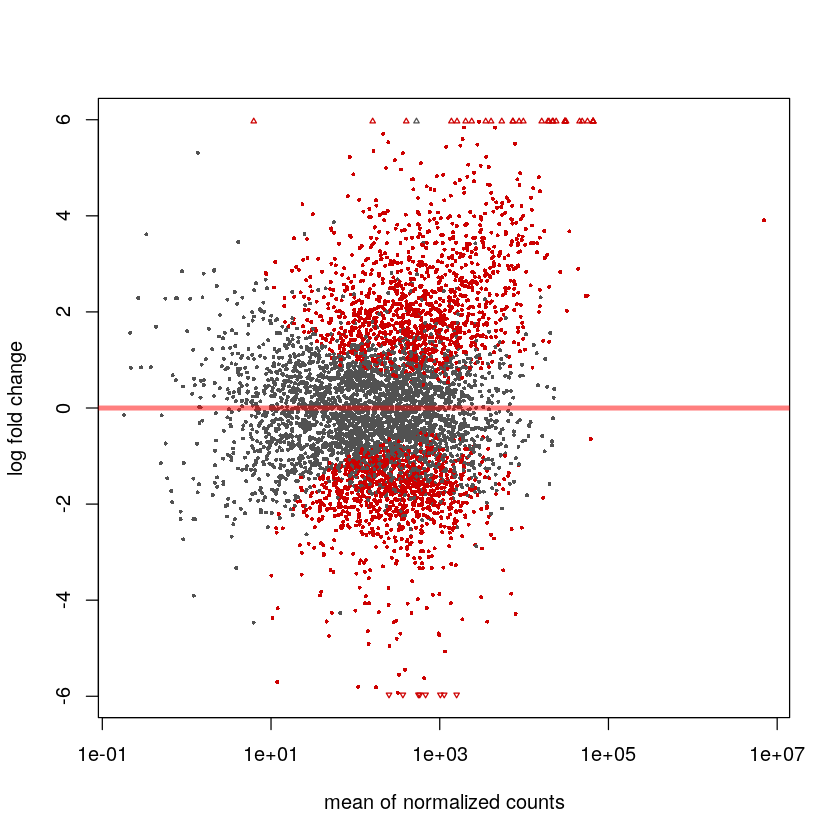

In [12]:
#get normalised count data from DESeq2 object
res <- results(ddsTxi)
#generate MA plot of in vitro samples
#P value threshold 0.0001
pdf("DESeq_analysis/plots/in_vitro/MA_plot_final_samples.pdf")
plotMA(res,alpha=0.0001)
dev.off()
plotMA(res,alpha=0.0001)

#how many non-significant genes?
resNOTSIG <- res[which(res$padj > 0.0001),]
print(nrow(resNOTSIG))
#how many signifiant genes?
resSIG <- res[which(res$padj < 0.0001),]
print(nrow(resSIG))




In [13]:
#pairwise comparisons of different growth phases
res_richlog_richloglate <- results(
    ddsTxi,
    contrast =c("media","rich_log","rich_log_late"))
res_richlog_minimal <- results(
    ddsTxi,
    contrast=c("media","rich_log","minimal_log_late_log"))
res_richloglate_minimal <- results(
    ddsTxi,
    contrast=c("media","rich_log_late","minimal_log_late_log"))
res_richlog_starv <- results(
    ddsTxi,
    contrast=c("media","rich_log","starved_early"))
res_richloglate_starv <- results(
    ddsTxi,
    contrast=c("media","rich_log_late","starved_early"))

#plot Padj frequency distribution for pairwise comparisons of growth phase
pdf("DESeq_analysis/plots/in_vitro/hist_richlog_richloglate.pdf")
hist(res_richlog_richloglate$padj,
     breaks=100,
     col="skyblue",
     border="slateblue",
     main="Rich media, log vs late log",
     xlab="Padj")
dev.off()
pdf("DESeq_analysis/plots/in_vitro/hist_richlog_minimal.pdf")
hist(res_richlog_minimal$padj,
     breaks=100,
     col="skyblue",
     border="slateblue",
     main="Rich media (log phase) vs Minimal media (log/late log phase)",
     xlab="Padj")
dev.off()
pdf("DESeq_analysis/plots/in_vitro/hist_richloglate_minimal.pdf")
hist(res_richloglate_minimal$padj,
     breaks=100,
     col="skyblue",
     border="slateblue",
     main="Rich media (log/late log phase) vs Minimal media (log/late log phase)",
     xlab="Padj")
dev.off()
pdf("DESeq_analysis/plots/in_vitro/hist_richlog_starved.pdf")
hist(res_richlog_starv$padj,
     breaks=100,
     col="skyblue",
     border="slateblue",
     main="Rich media (log phase) vs Starved media (early)",
     xlab="Padj")
dev.off()
pdf("DESeq_analysis/plots/in_vitro/hist_richloglate_starved.pdf")
hist(res_richloglate_starv$padj, 
     breaks=100, 
     col="skyblue",
     border="slateblue",
     main="Rich media (log/late log phase) vs Starved (early)",
     xlab="Padj")
dev.off()


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

By comparing frequencies of significantly DEGs for different comparisons we can see that:
- Rich media conditions are distinct from each other 
- Rich media (log phase) is more similar to minimal media (log/late log), with x% fewer significant DEGs 

Combining the rich media conditions may partly negate the effect of growth phase

In [14]:
#Data for Table 4.6
#how many significantly differentially expressed
#genes are there between different samples (Padj < 0.0001)
#filter by padj <0.0001
res_richlog_vs_starvSIG <- res_richlog_starv[
    which(res_richlog_starv$padj < 0.0001),]
res_richlog_vs_minSIG <- res_richlog_minimal[
    which(res_richlog_minimal$padj < 0.0001),]
res_richloglate_vs_starvSIG <- res_richloglate_starv[
    which(res_richloglate_starv$padj < 0.0001),]
res_richloglate_vs_minSIG <- res_richloglate_minimal[
    which(res_richloglate_minimal$padj < 0.0001),]
res_richlog_vs_richloglateSIG <- res_richlog_richloglate[
    which(res_richlog_richloglate$padj < 0.0001),]

print(c(nrow(res_richlog_vs_starvSIG),
        nrow(res_richlog_vs_minSIG),
        nrow(res_richloglate_vs_starvSIG),
        nrow(res_richloglate_vs_minSIG),
        nrow(res_richlog_vs_richloglateSIG)))

[1] 2501  548 1669 1182 1385


## Comparison between growth medium

In [15]:
#make table of countfiles for all experiments
sampleTable <-read.csv("mapping/sample_list_media_only.csv",
    header = TRUE)

#make table of experimental design
rownames(sampleTable) <- colnames(txi.kallisto.tsv$counts)

#create DESeq2 object with media as factor
ddsTxi <- DESeqDataSetFromTximport(
    txi.kallisto.tsv,
    colData = sampleTable,
    design = ~ media)
#filter rows with no counts
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,] 
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)

using counts and average transcript lengths from tximport
estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


      Length        Class         Mode 
        5818 DESeqDataSet           S4 

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


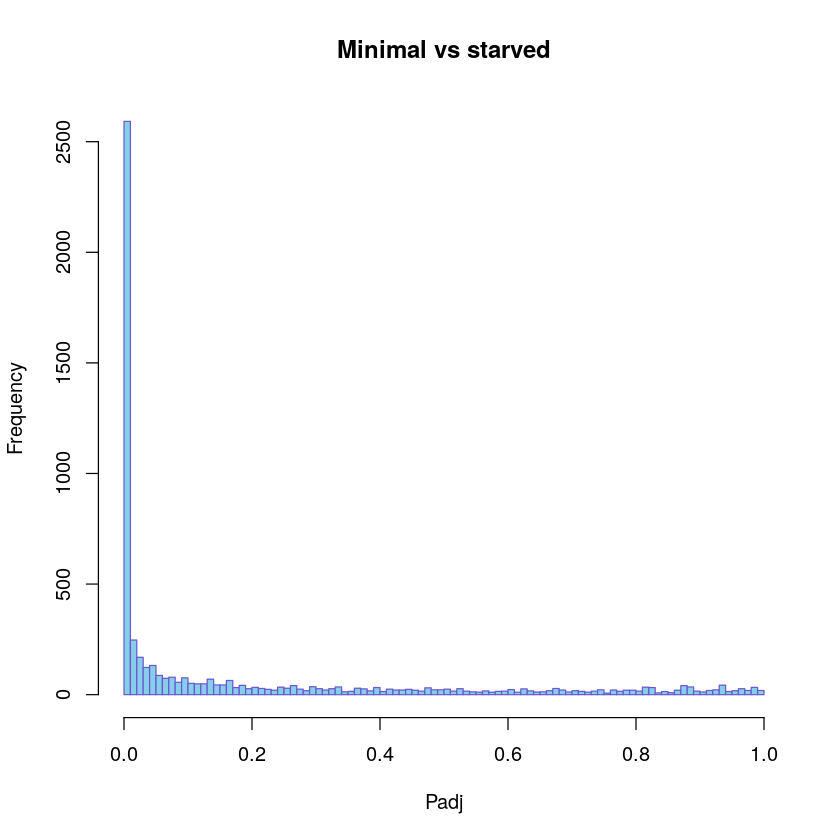

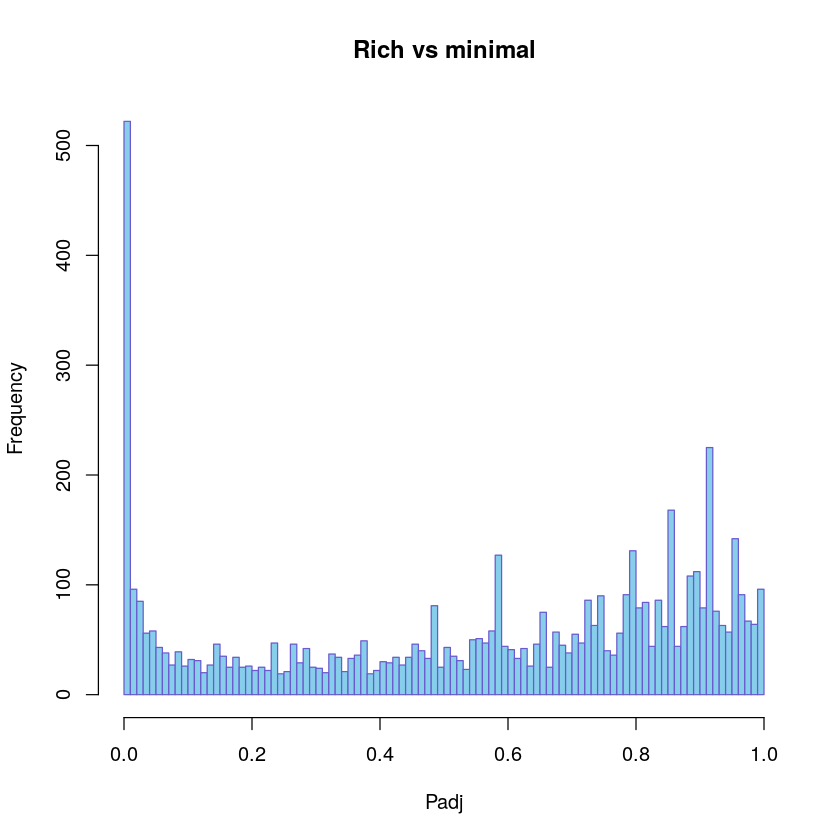

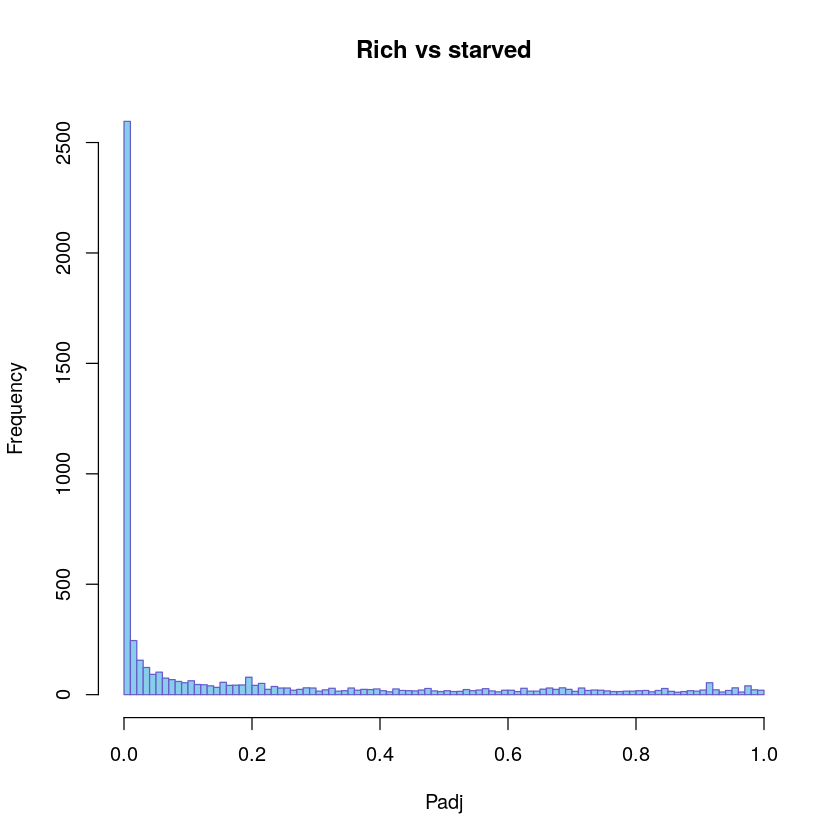

In [16]:
#pairwise comparisons of different growth media
res.test <- results(ddsTxi)
res_rich_vs_starv <- results(ddsTxi,
                             contrast = c("media",
                                          "starved",
                                          "rich"))
res_rich_vs_min <- results(ddsTxi,
                           contrast = c("media",
                                        "minimal",
                                        "rich"))
res_min_vs_starv <- results(ddsTxi,
                            contrast = c("media",
                                         "starved",
                                         "minimal"))

#plot Padj frequency distribution 
#for pairwise comparisons of growth medium
#pdf("DESeq_analysis/plots/in_vitro/hist_minimal_starved.pdf")
hist(res_min_vs_starv$padj,
     breaks=100, 
     col="skyblue",
     border="slateblue",
     main="Minimal vs starved",
     xlab="Padj")
#dev.off()
#pdf("DESeq_analysis/plots/in_vitro/hist_rich_minimal.pdf")
hist(res_rich_vs_min$padj,
     breaks=100, 
     col="skyblue",
     border="slateblue", 
     main="Rich vs minimal",
     xlab="Padj")
#dev.off()
#pdf("DESeq_analysis/plots/in_vitro/hist_rich_starved.pdf")
hist(res_rich_vs_starv$padj,
     breaks=100, 
     col="skyblue", 
     border="slateblue",
     main="Rich vs starved",
     xlab="Padj")
#dev.off()


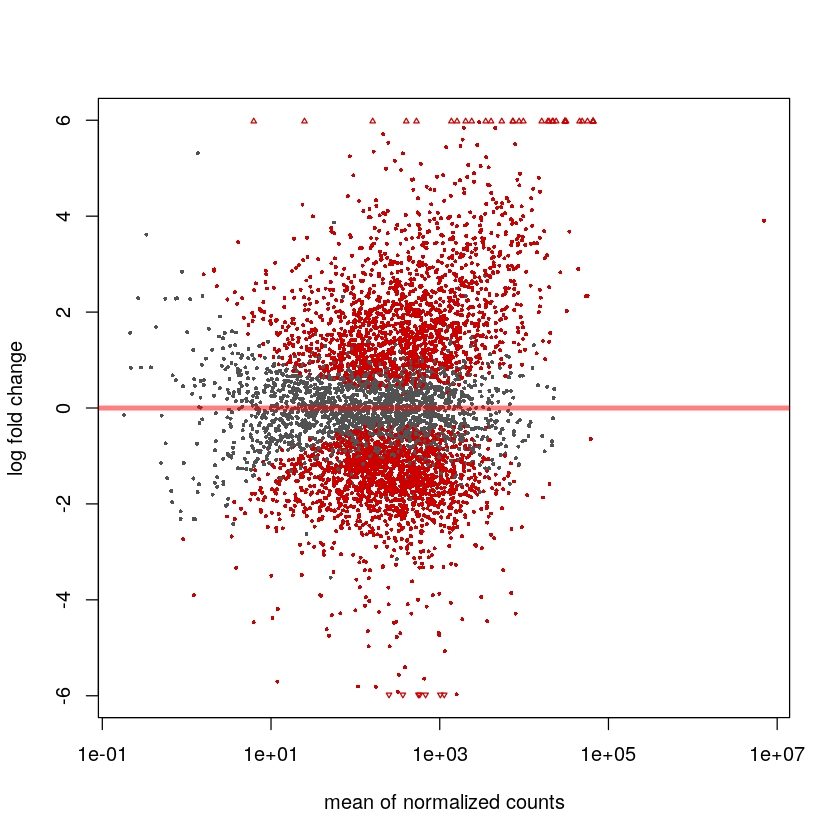

In [17]:
#generate MA plot of significant DEGs
#in growth media comparisons
#pdf("DESeq_analysis/plots/in_vitro/MA_plot_sig_DEGs.pdf")
plotMA(res.test)#, ylim=c(-2,2))
#dev.off()


[1] 1572  257 1561


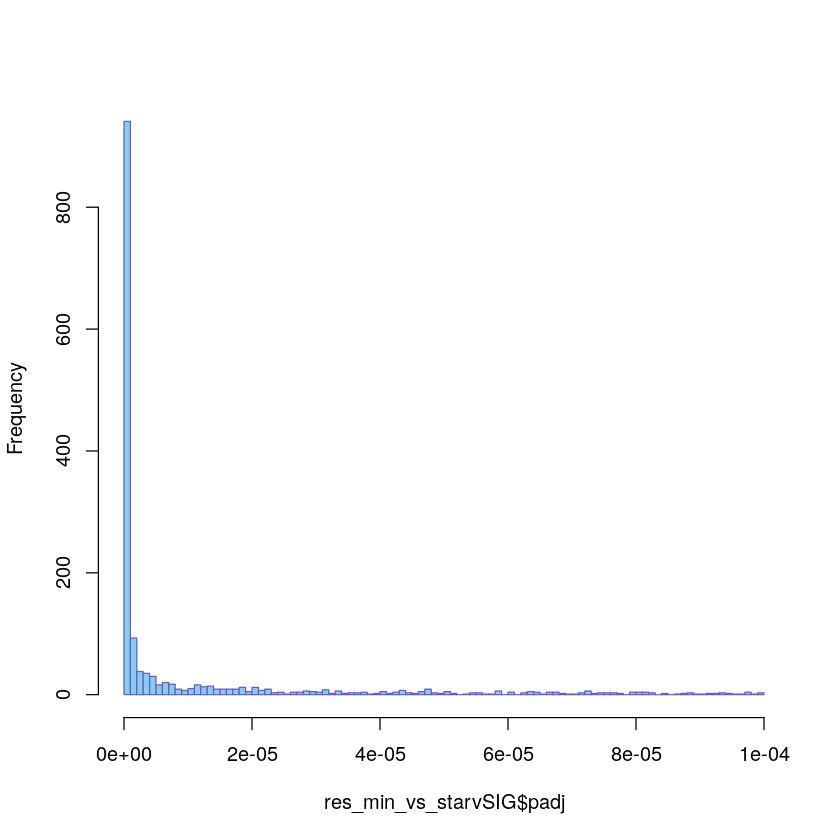

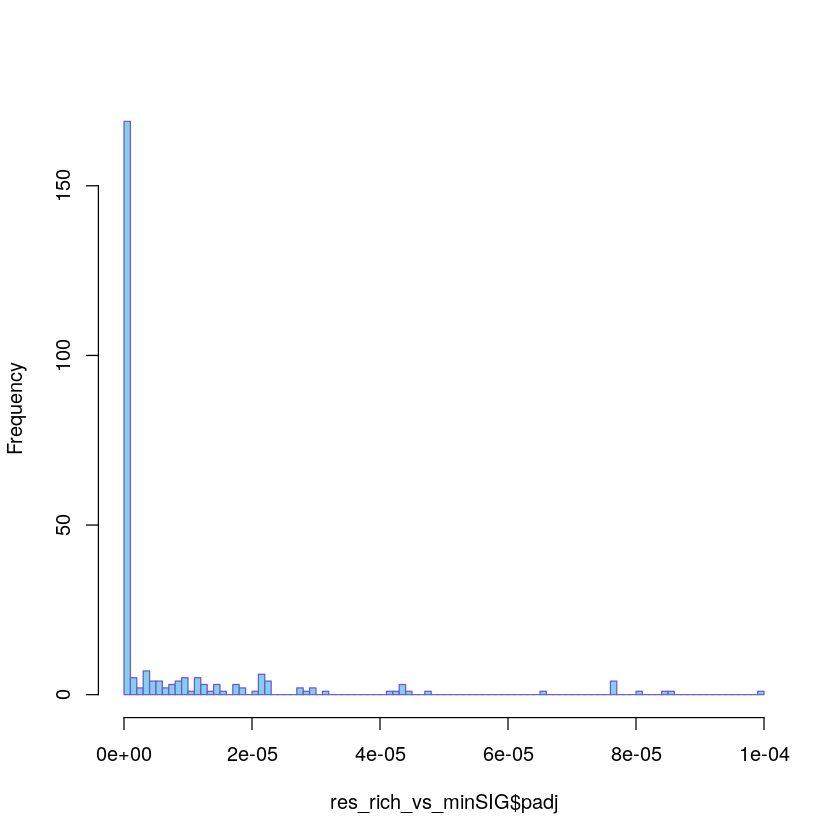

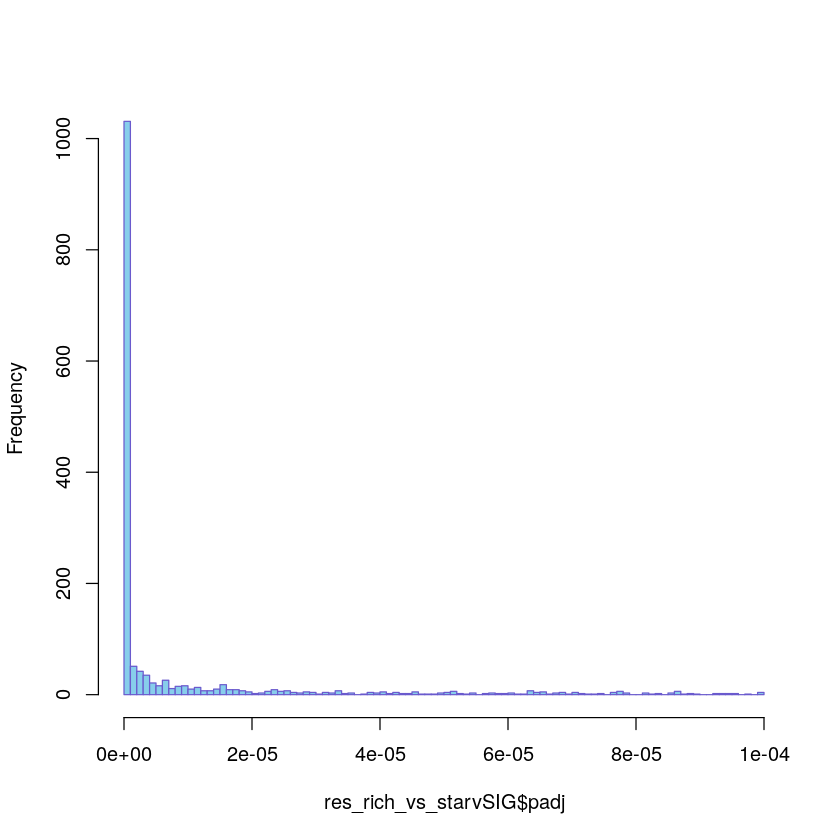

In [18]:
#taking a closer look at the distribution of small p values
#filter media comparisons by Padj <0.0001
res_rich_vs_starvSIG <- res_rich_vs_starv[
    which(res_rich_vs_starv$padj < 0.0001),]
res_rich_vs_minSIG <- res_rich_vs_min[
    which(res_rich_vs_min$padj < 0.0001),]
res_min_vs_starvSIG <- res_min_vs_starv[
    which(res_min_vs_starv$padj < 0.0001),]

#how many genes are below this significance threshold? 
print(c(nrow(res_rich_vs_starvSIG),
        nrow(res_rich_vs_minSIG),
        nrow(res_min_vs_starvSIG)))

#plot Padj frequency distribution (Padj < 0.0001) 
#for pairwise comparisons of growth medium
hist(res_min_vs_starvSIG$padj,
     breaks=100, 
     col="skyblue", 
     border="slateblue", 
     main="")
hist(res_rich_vs_minSIG$padj,
     breaks=100,
     col="skyblue", 
     border="slateblue",
     main="")
hist(res_rich_vs_starvSIG$padj,
     breaks=100,
     col="skyblue", 
     border="slateblue",
     main="")

#save media comparisons for all genes
#signifcantly differentially expressed genes as csv
write.csv(res_rich_vs_min,
          file="DESeq_analysis/rich_vs_min.csv")
write.csv(res_rich_vs_starv,
          file="DESeq_analysis/rich_vs_starv.csv")
write.csv(res_min_vs_starv,
          file="DESeq_analysis/min_vs_starv.csv")

write.csv(res_rich_vs_minSIG,
          file="DESeq_analysis/rich_vs_minSIG.csv")
write.csv(res_rich_vs_starvSIG,
          file="DESeq_analysis/rich_vs_starvSIG.csv")
write.csv(res_min_vs_starvSIG,
          file="DESeq_analysis/min_vs_starvSIG.csv")


In [19]:
#order pairwise media comparison by Padj values
top_rich_vs_starv <- res_rich_vs_starv[
    order(res_rich_vs_starv$padj),]
top_rich_vs_min <- res_rich_vs_min[
    order(res_rich_vs_min$padj),]
top_min_vs_starv <- res_min_vs_starv[
    order(res_min_vs_starv$padj),]

#select genes with the top 250 smallest
#Padj values for each pairwise media comparison
top_rich_vs_starv <- top_rich_vs_starv[1:250,]
top_rich_vs_min <- top_rich_vs_min[1:250,]
top_min_vs_starv <- top_min_vs_starv[1:250,]

#save top 250 genes to csv
write.csv(top_rich_vs_min,
          file="DESeq_analysis/top_250_rich_vs_min.csv")
write.csv(top_rich_vs_starv,
          file="DESeq_analysis/top_250_rich_vs_starv.csv")
write.csv(top_min_vs_starv,
          file="DESeq_analysis/top_250_min_vs_starv.csv")


## How do DEGs compare across media types?

Which DEGs are unique or shared between pairwise media comparisons?

In [20]:
#lets make a venn diagram!
library(limma)

#get DEG gene IDs for each pairwise comparison
rich_vs_starv_names <- rownames(
    res_rich_vs_starv[
        which(res_rich_vs_starv$padj < 0.0001),])
rich_vs_min_names <- rownames(
    res_rich_vs_min[
        which(res_rich_vs_min$padj < 0.0001),])
min_vs_starv_names <- rownames(
    res_min_vs_starv[
        which(res_min_vs_starv$padj < 0.0001),])

#get list of all gene names that are significantly 
#differentially expressed in at least one pairwise media comparison
combo<-unique(c(rich_vs_starv_names,
                rich_vs_min_names,
                min_vs_starv_names))

#make counts for venn diagram
rvs <- combo %in% rich_vs_starv_names
rvm <- combo %in% rich_vs_min_names
mvs <- combo %in% min_vs_starv_names
counts.t <- cbind(rvs,rvm,mvs)
results.t <- vennCounts(counts.t)


Attaching package: ‘limma’

The following object is masked from ‘package:DESeq2’:

    plotMA

The following object is masked from ‘package:BiocGenerics’:

    plotMA



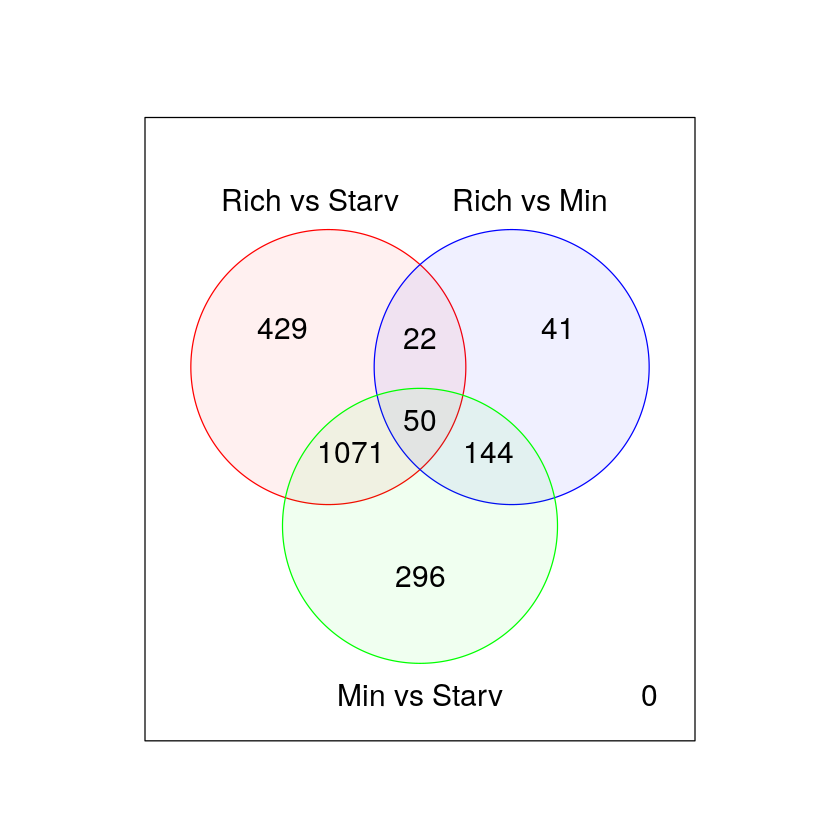

In [21]:
#plot venn diagram
#pdf("DESeq_analysis/plots/in_vitro/venndiagram.pdf")
vennDiagram(results.t, 
            names = c("Rich vs Starv",
                      "Rich vs Min",
                      "Min vs Starv"),
            circle.col = c("red",
                           "blue",
                           "green"))
#dev.off()


49 genes are significantly differentially expressed for all comparisons of media type.

In [22]:
#which genes have significant diff in
#gene expression across all comparisons?
all <- c(rich_vs_starv_names,
         rich_vs_min_names,
         min_vs_starv_names)
all <- as.data.frame(table(unlist(all)))
intersect <- all[which(all$Freq == 3),]
print(intersect$Var1)
test <- intersect[1]
print(test)
write.table(test,
            sep = '\t',
            col.names = FALSE, 
            quote=FALSE,
            row.names=FALSE,
            file="DESeq_analysis/intersect_genes.txt")

 [1] IYO_000115 IYO_000615 IYO_000645 IYO_001820 IYO_002420 IYO_003330
 [7] IYO_004235 IYO_005630 IYO_005635 IYO_006070 IYO_008300 IYO_009280
[13] IYO_009370 IYO_009375 IYO_009440 IYO_009565 IYO_009570 IYO_009585
[19] IYO_009590 IYO_010165 IYO_010790 IYO_011010 IYO_011305 IYO_011770
[25] IYO_011850 IYO_012490 IYO_012615 IYO_012775 IYO_012780 IYO_013255
[31] IYO_014290 IYO_014420 IYO_016485 IYO_017220 IYO_019195 IYO_020920
[37] IYO_021165 IYO_021360 IYO_022590 IYO_022595 IYO_022600 IYO_023630
[43] IYO_025445 IYO_027255 IYO_027265 IYO_028000 IYO_028555 IYO_028715
[49] IYO_028760 IYO_029675
2053 Levels: IYO_000005 IYO_000010 IYO_000015 IYO_000045 ... IYO_029910
           Var1
13   IYO_000115
54   IYO_000615
59   IYO_000645
148  IYO_001820
201  IYO_002420
260  IYO_003330
306  IYO_004235
388  IYO_005630
389  IYO_005635
424  IYO_006070
580  IYO_008300
655  IYO_009280
663  IYO_009370
664  IYO_009375
670  IYO_009440
678  IYO_009565
679  IYO_009570
681  IYO_009585
682  IYO_009590
724  IYO_0101

How do these 49 genes change in expression?

In [23]:
library(reshape2)
#get count data for these genes
intersect <- as.vector(
    read.delim("intersect_genes.txt",
               header=FALSE))
intersect <- unlist(intersect)
intersect.result <- assay(ddsTxi)[ intersect, ]

#get logfold2 change for all genes for each comparison
rvs <- results(
    ddsTxi, 
    contrast = c("media",
                 "starved",
                 "rich"))
rvm <- results(
    ddsTxi, 
    contrast = c("media",
                 "minimal",
                 "rich"))
mvs <- results(
    ddsTxi,
    contrast = c("media",
                 "starved",
                 "minimal"))
logfold <- cbind(rvs$log2FoldChange,
                 rvm$log2FoldChange,
                 mvs$log2FoldChange)
colnames(logfold) <- c("rvs",
                       "rvm",
                       "mvs")
rownames(logfold) <- c(rownames(rvs))

#filter 24 genes of interest
logfold <- logfold[intersect,]
logfold.m <- melt(logfold)

#plot as heatmap
p <- (ggplot(logfold.m,aes(x=logfold.m$Var1,y=logfold.m$Var2))
 +coord_equal(ratio=1)+geom_tile(aes(fill=logfold.m$value))
 +scale_fill_gradient2(low="red",high="green",mid="white")
 +theme(axis.text.x = element_text(angle=90,size=5)))

p

Warning message in file(file, "rt"):
“cannot open file 'intersect_genes.txt': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


## Clustering DEGs by expression pattern across comparison

DEGs are clustered with K-means. First, estimate the number of clusters needed to capture most of the variance. A cluster number of 10 was chosen based on this estimate.

In [ ]:
#kmeans clustering of DEGs

logfolds <- rld
scaled_data = as.matrix(scale(assay(rld)))
kmm <- kmeans(scaled_data,
              3,
              nstart = 50,
              iter.max = 15)
#Elbow Method for finding the optimal number of clusters
set.seed(123)

# Compute and plot wss for k = 2 to k = 15.
k.max <- 20
data <- logfold
wss <- sapply(1:k.max, 
              function(k){
                  kmeans(data,
                         k, 
                         nstart=50,
                         iter.max = 15 )$tot.withinss})
plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares",
     main="Variance captured by different k-means cluster number")


##Clustering and visualisation

All genes are separated into 10 clusters. The difference in log2foldchange across media comparisons is then shown for significant DEGs within each cluster.

In [ ]:
#re-use media comparisons from earlier
#filter by Padj < 0.0001

rvs <- rvs[which(rvs$padj < 0.0001),]
rvm <- rvm[which(rvm$padj < 0.0001),]
mvs <- mvs[which(mvs$padj < 0.0001),]

#make table of log2fold change for significant expressed genes
logfold <- cbind(rvs$log2FoldChange,
                 rvm$log2FoldChange,
                 mvs$log2FoldChange)
colnames(logfold) <- c("rvs","rvm","mvs")
rownames(logfold) <- c(rownames(rvs))
head(logfold)



In [ ]:
library(tidyverse)

#format data for clustering 
scaled_data <- as.data.frame(logfold)
for_clust  <- scaled_data 


#kmeans
max_itr <-  50
#number of clusters (n=10 based on previous graph)
n_clust  <-  10
#reproduce the clusters
set.seed(123)  
kmeans_out  <- kmeans(for_clust,
                      n_clust,
                      iter.max = max_itr)

#add cluster labels to original matrix 
data_with_cust_info <- scaled_data %>% 
    mutate(clust = paste("clust_",
                         kmeans_out$cluster,
                         sep = ""))


In [ ]:
#visualise each cluster 
data_with_cust_info %>% 
# 1 is index of column 'geneName' and 4 is index of column 'clust'
      gather(key = "variable" ,
             value = "value",
             -c(0,4)) %>% 
      group_by(variable) %>%  
      mutate(row_num =  1:n()) %>% 
      ggplot(aes(x = variable ,
                 y = value ,
                 group = row_num)) +   
      geom_point() +  
      geom_line(alpha = 1 ,
                aes(col = as.character(clust))) + 
      theme_bw() +  
      theme(legend.position = "none" ,
            axis.text.x = element_text(angle = 90
                                       , vjust = 0.4)) +
      labs(x="Media comparison",
           y="Log2FC") +
      facet_wrap(~clust)

In [ ]:
row.names(data_with_cust_info) <- rownames(logfold)
print(head(data_with_cust_info))
write.csv(data_with_cust_info,
          file="transcriptomes/in_vitro/clusters/DE_clustered.csv")

In [ ]:
#dds <- estimateSizeFactors(ddsTxi)
#counts(dds, normalized=TRUE)
#head(assay(rld))
#tmp <- plotCounts(ddsTxi, 
#                  gene=which.min(res.test$padj),
#                  intgroup="media",returnData = TRUE)
#head(tmp)

#sampleTable <-read.csv(
#    file.path("~/Dropbox/PhD/Psa/RNAseq/transcriptomes/Psa_RNAseq/kallisto/countfiles",
#              "sample_list_combo_2.csv"), 
#    header = TRUE)
#new table:
sampleTable <-read.csv(
    file.path(
        "transcriptomes/in_vitro/kallisto/countfiles",
        "sample_list_combo_2.csv"),
    header = TRUE)
dds2 <- DESeqDataSetFromTximport(
    txi.kallisto.tsv,
    colData = sampleTable,
    design= ~ media)
#filter rows with no counts
dds2 <- dds2[rowSums(counts(dds2)) > 1,] 
dds2 <- DESeq(dds2)
summary(dds2)



In [ ]:
#collapse biological replicates for media type 
ddsColl <- collapseReplicates(dds2, 
                              dds2$media, 
                              dds2$run)
ddsColl <- assay(ddsColl)
#make dataframe of total counts for each media type
ddsColl <- as.data.frame(ddsColl)

#get mean counts (divide by number of replicates)
ddsColl$minimal <- ddsColl$minimal/2
ddsColl$rich <- ddsColl$rich/5
ddsColl$starved <- ddsColl$starved/4
head(ddsColl)

#log2 transformation of counts for scaling
ddsColl <- log2(ddsColl)

#remove empty rows
ddsColl <- ddsColl[rowSums(ddsColl) > 0,]

In [ ]:
#prep data
logfold <- ddsColl
colnames(logfold) <- c("a_rich",
                       "b_minimal",
                       "c_starved")
rownames(logfold) <- c(rownames(ddsColl))

#use previous dataset to filter genes (p<0.0001)
#genes already in correct order 
logfold <- logfold[rownames(for_clust),] 

scaled_data <- as.data.frame(logfold)
for_clust  <- scaled_data 
sampleOrder <- c("a_rich",
                 "b_minimal",
                 "c_starved",
                 "clust")

#add cluster info to counts table and plot
data_with_cust_info <- scaled_data %>% 
    mutate(clust = paste("clust_", kmeans_out$cluster,sep = ""))
    data_with_cust_info %>% 
      gather(key = "variable" , 
             value = "value",
             -c(0,4)) %>%  
      group_by(variable) %>%  
      mutate(row_num =  1:n()) %>% 
      ggplot(aes(x = variable , y = value , group = row_num)) +   
      geom_point() +  
      geom_line(alpha = 1 , aes(col = as.character(clust))) + 
      theme_bw() +  
      theme(legend.position = "none" , 
            axis.text.x = element_text(angle = 90 ,
                                       vjust = 0.4)) +
      labs(x="Media",
           y="Counts (log2)") +
      facet_wrap(~clust)
